# MULTIVARIATE ANALYSIS CODE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.ticker import PercentFormatter

font = {'family':'Bahnschrift', 'fontsize' : 16}

from matplotlib.gridspec import GridSpec as gspec

%matplotlib inline

## Radon concentrations
We import the radon concentrations measured. (RAW DATA)

In [7]:
DF = pd.read_excel('Radon concentrations data/Results_LR115.xlsx')

DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] #Drop NA data
DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Concentracion_Bq_m3'], axis = 1) #Add error column
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))

DF_data = DF_data.set_index('ID_casa')
DF_data

,ID_muestra,dias_muestreo,Concentracion_Bq_m3,Contramuestra,Resultado,Error_perc
ID_casa,,,,,,
1,20,35,175.00,NaN,175.000,NaN
10,3,35,46.86,NaN,46.860,NaN
16,7,35,81.80,NaN,81.800,NaN
17,16,36,173.91,180.26,177.085,3.651314
19,19,35,107.13,130.00,118.565,21.347895
22,4,35,61.80,NaN,61.800,NaN
24,14,36,40.75,50.00,45.375,22.699387
26,15,36,182.30,170.00,176.150,6.747120
28,5,35,15.40,NaN,15.400,NaN


## Import data of all the variables

In [8]:
# Geologic + construction variables
DF_Caract = pd.read_csv('Independent variables/Houses_Age_Basement_Geo.csv').set_index('ID')
DF_IGAC = pd.read_csv('Independent variables/Houses_Urban.csv')[['ID','SueCodigo']].set_index('ID')

#Meteorologic data
DF_PREC = pd.read_excel('Independent variables/Precipitacion_Casas_IDW.xlsx').set_index('ID')
DF_TEMP = pd.read_excel('Independent variables/Temperatura_Casas_IDW.xlsx').set_index('ID')

DF_PREC.columns = ['OBJECTID', 'COUNT', 'AREA', 'Precipitacion_mes']
DF_TEMP.columns = ['OBJECTID', 'COUNT', 'AREA', 'Temperatura']

# Subsidence
df_subsidence = pd.read_excel('Independent variables/VerticalVelocity_HousesBogota_InSAR.xls')
df_subsidence = df_subsidence.iloc[:,[1,-1]]
df_subsidence.columns = ['ID','Vertical_velocity']
df_subsidence = df_subsidence.set_index('ID')

DF_JOIN = DF_data.join(DF_Caract)
DF_JOIN = DF_JOIN.join(DF_IGAC)
DF_JOIN = DF_JOIN.join(DF_PREC['Precipitacion_mes'])
DF_JOIN = DF_JOIN.join(DF_TEMP['Temperatura'])
DF_JOIN = DF_JOIN.join(df_subsidence)

In [9]:
# House age dicrete variable
list_edad = []

for i in DF_JOIN.edad_casa:
    if i == '0 -.10 aÃ±os':
        list_edad.append(1)
    elif i == '11 - 20 aÃ±os':
        list_edad.append(2)
    elif i == '21 - 30 aÃ±os':
        list_edad.append(3)
    elif i == '31 - 40 aÃ±os':
        list_edad.append(4)
    elif i == '41 aÃ±os en adelante':
        list_edad.append(5)

DF_JOIN.edad_casa = list_edad

# Create geologic dummy variables
for i in DF_JOIN.Descripcion_GeoMapCol.unique():
    DF_JOIN['Lito_SGC_'+i.replace(' ','_')[:10]] = DF_JOIN.apply(lambda df : 1 if df.Descripcion_GeoMapCol == i else 0, axis = 1)
    
DF_JOIN['Urbano_dummy'] = DF_JOIN.SueCodigo.apply(lambda df : 1 if df == 1 else 0)

## Basic statistics

In [10]:
# Selected variables for Statistical analysis
DF_JOIN = DF_JOIN[['Resultado',
                   'DistanciaFalla',
                   'sotano_dummy',
                   'edad_casa',
                   'Lito_SGC_Arcillas,_',
                   'Lito_SGC_Abanicos_a',
                   'Lito_SGC_Shales,_ca',
                   'Precipitacion_mes',
                   'Temperatura',
                   'Urbano_dummy',
                   'Vertical_velocity'
                  ]]

Variables = ['Fault proximity [m]',
             'Basement dummy',
             'House age',
             'Lithology 1 dummy',
             'Lithology 2 dummy',
             'Lithology 3 dummy',
             'Precipitation [mm]',
             'Temperature [°C]',
             'Urban dummy', 
             'Vertical velocity'
            ]

DF_JOIN.to_csv('Processed_DataFrame.csv')
DF_JOIN.describe()

,Resultado,DistanciaFalla,sotano_dummy,edad_casa,"Lito_SGC_Arcillas,_",Lito_SGC_Abanicos_a,"Lito_SGC_Shales,_ca",Precipitacion_mes,Temperatura,Urbano_dummy,Vertical_velocity
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,115.667333,6851.554737,0.233333,3.566667,0.900000,0.066667,0.033333,104.602221,14.214016,0.800000,2.236616
std,80.552708,3194.114214,0.430183,1.250747,0.305129,0.253708,0.182574,14.159199,0.234194,0.406838,0.432698
min,15.400000,97.923422,0.000000,1.000000,0.000000,0.000000,0.000000,71.539902,13.701771,0.000000,1.541482
25%,50.595000,5055.807810,0.000000,3.000000,1.000000,0.000000,0.000000,100.719971,14.176495,1.000000,1.975335
50%,102.837500,6623.320848,0.000000,4.000000,1.000000,0.000000,0.000000,105.389690,14.238723,1.000000,2.071670
75%,154.250000,8662.545657,0.000000,4.750000,1.000000,0.000000,0.000000,112.609728,14.275739,1.000000,2.397878
max,407.000000,13435.781270,1.000000,5.000000,1.000000,1.000000,1.000000,137.179352,15.107800,1.000000,3.318798


## Independent variable caracterization

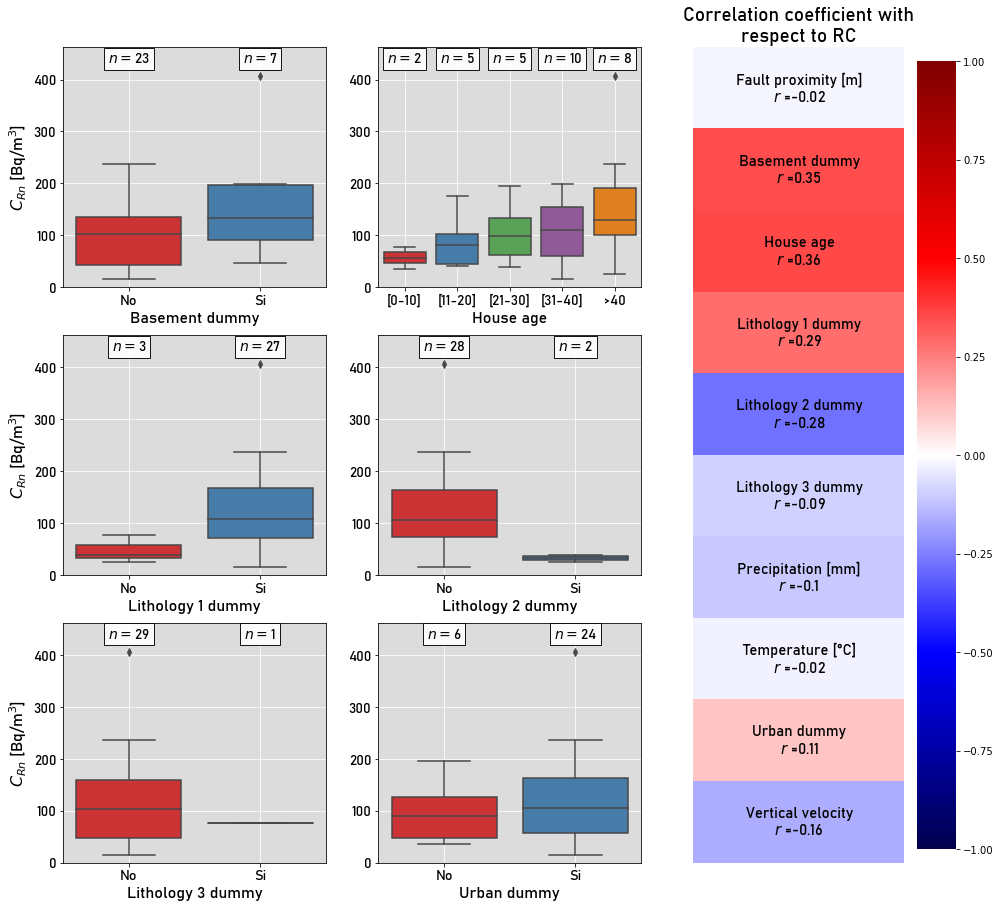

In [11]:
fig = plt.figure(figsize = (16,15))
k = 0

for i in [2, 3, 4, 5, 6, 9]:
    
    if k<2:
        plt.subplot2grid((3,3), (0,k))
    elif k < 4:
        plt.subplot2grid((3,3), (1,k-2))
    else:
        plt.subplot2grid((3,3), (2,k-4))
    k+=1
    
    plt.ylim((0,462))
    ax=plt.gca()
    ax.set_facecolor('gainsboro')
    ax.set_axisbelow(True)
    
    ax2 = sns.boxplot(y = DF_JOIN.Resultado, x = DF_JOIN.iloc[:,i], palette = sns.color_palette("Set1"), zorder = 2)
    
    for j in range(len(DF_JOIN.iloc[:,i].unique())):
        if i == 3:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j+1)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['[0-10]', '[11-20]', '[21-30]', '[31-40]', '>40'], family = 'bahnschrift', fontsize=14)
        else:
            plt.text(j,440,'$n = $'+str(sum(DF_JOIN.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['No', 'Si'], family = 'bahnschrift', fontsize=14)
    ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
    if (k != 1) and (k!=3) and (k!=5):
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('$C_{Rn}$ [Bq/m$^3$]', fontsize=16, family = 'bahnschrift')
    ax2.set_xlabel(Variables[i-1], fontsize=16, family = 'bahnschrift')
    ax2.grid(color = 'w', zorder = -3)
    
ax7 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n$r$ =' +str(round(DF_JOIN.corr()['Resultado'].iloc[i+1], 2)))

ax = sns.heatmap(pd.DataFrame(DF_JOIN.corr()['Resultado'].iloc[1:]), center = 0, vmin = -1, vmax = 1, cmap = 'seismic')
ax.set_yticklabels(Val, rotation = 0, x = 0.52, ha = 'center', family='bahnschrift', fontsize = 15)
ax.tick_params(length = 0)
ax.set_xticklabels([''], rotation = 0)
ax.set_title('Correlation coefficient with\nrespect to RC', family='bahnschrift', fontsize = 19)

fig.savefig('Figures/Caracterization.png', dpi = 250, bbox_inches = 'tight')

## Principal component Analysis

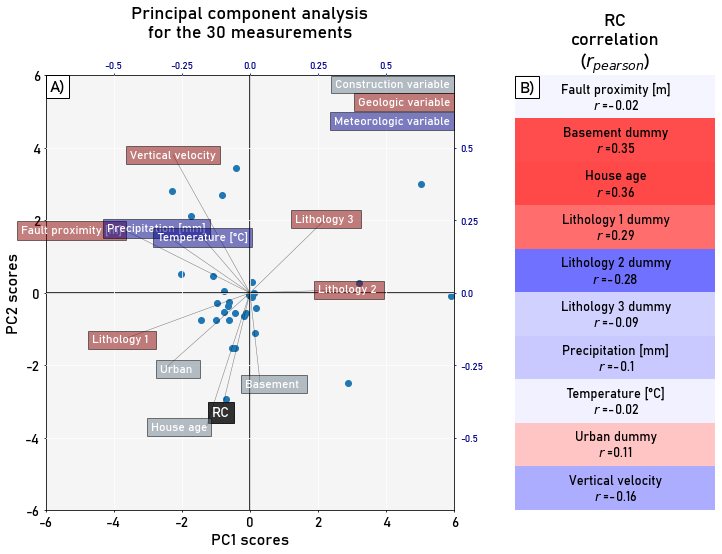

In [12]:
df_PCA = DF_JOIN

# Standarization
df_PCA = df_PCA.apply(lambda df : (df - np.mean(df))/np.std(df) )

Variables.insert(0,'RC')
df_PCA.columns = Variables

df_ = pd.DataFrame(df_PCA.corr().iloc[0,1:])

n_PCA = 5
pca = PCA(n_PCA)
A_postPCA = pca.fit_transform(df_PCA)
A_postPCA = pd.DataFrame(A_postPCA)

# Name the columns
cols = []
for i in range(len(A_postPCA.T)):
    cols.append('PC'+str(i+1))

A_postPCA.columns = cols

EigenVectors = pd.DataFrame(pca.components_.T)

fig = plt.figure(figsize = (12,8))

gs = gspec(8,13)

ax1=fig.add_subplot(gs[:,:8], label="1")
ax2=fig.add_subplot(gs[:,:8], label="2", frame_on=False)

ax1.scatter(A_postPCA.PC1, A_postPCA.PC2)

ax1.set_xlabel("PC1 scores", color="k", fontfamily = 'bahnschrift', fontsize = 16)
ax1.set_ylabel("PC2 scores", color="k", fontfamily  = 'bahnschrift', fontsize = 16)
ax1.tick_params(axis='x', colors="k", length = 2)
ax1.tick_params(axis='y', colors="k", length = 2)
ax2.set_xticks(np.arange(-6,7,2))
ax2.set_yticks(np.arange(-6,7,2))
ax1.set_yticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)
ax1.set_xticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)

plt.grid(True, color = 'w')

ax1.axhline(0,c='k')
ax1.axvline(0,c='k')

ax1.set_xlim(-6,6)
ax1.set_ylim(-6,6)


for i in range(len(EigenVectors)):
    ax2.plot([0,EigenVectors.iloc[i,0]],[0, EigenVectors.iloc[i,1]], c = 'k', lw = 0.5, alpha=0.5)
    if (i == 2)|(i == 9):
        plt.text(EigenVectors.iloc[i,0]+0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 3):
        plt.text(EigenVectors.iloc[i,0]-0.1, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 4)|(i == 5)|(i == 6)|(i == 10):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 1):
        plt.text(EigenVectors.iloc[i,0]-.2, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 7)|(i == 8):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkblue', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    else:
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='k', alpha = 0.8), fontsize = 14, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
        

    
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xticks(np.arange(-0.5,.7,.25))
ax2.set_yticks(np.arange(-0.5,.7,.25))
ax2.set_yticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.set_xticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.tick_params(axis='x', colors="darkblue",length = 2)
ax2.tick_params(axis='y', colors="darkblue",length = 2)

ax2.set_xlim(-.75,.75)
ax2.set_ylim(-.75,.75)

plt.text(-0.735,.736,'A)', ha = 'left', va='top', fontsize = 16, bbox = dict(facecolor='w'), fontfamily = 'bahnschrift')

plt.text(0.735,.736,'Construction variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='slategray', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.676,'Geologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkred', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.610,'Meteorologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkblue', alpha = 0.5), fontfamily = 'bahnschrift')


plt.title('Principal component analysis\nfor the 30 measurements', y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

ax1.set_facecolor('whitesmoke')

ax3 = fig.add_subplot(gs[:,9:], label='3')

df_ = df_PCA.corr(method = 'pearson').apply(lambda df : df[np.abs(df) >= 0.0])
df_ = df_.loc[df_.columns]
df_ = pd.DataFrame(df_.iloc[1:,0])
sns.heatmap(df_, cmap='seismic', vmin = -1,vmax = 1, alpha = 1, cbar = False, zorder = -2)

ax3.tick_params(axis='x', length = 0)
ax3.tick_params(axis='y', length = 0)

Val = []
for i in range(len(df_PCA.columns)-1):
    Val.append(list(df_PCA.columns)[i+1] + '\n$r$ =' +str(round(df_.iloc[i][0], 2)))
    
ax3.set_yticklabels(Val, rotation = 0, x = 0.52 , ha = 'center', family='bahnschrift', fontsize = 13, color = 'k', zorder = 5)

ax3.set_xticklabels([''], rotation = 0)

plt.text(0.02,0.1,'B)', ha = 'left', va='top', fontsize = 16, bbox = dict(facecolor='w'), fontfamily = 'bahnschrift')

plt.title('RC\ncorrelation\n($r_{pearson}$)',  y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

fig.savefig('Figures/PCA_RC.png', dpi  = 170, bbox_inches = 'tight')

Variables.remove('RC')

## Statistical regression models

In [13]:
X = DF_JOIN.iloc[:,1:]
y = DF_JOIN.iloc[:,0]
y_log = y.apply(lambda df: 1 if df >= 100 else 0)
X_log = X
X_log['Constante'] = np.ones(30)
X['Constante'] = np.ones(30)

### Linear regression

In [14]:
lin_reg = sm.OLS(y, X).fit(maxiter=1000000)
lin_reg.summary(alpha = 0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Resultado   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.182
Date:                Sun, 23 Jan 2022   Prob (F-statistic):              0.358
Time:                        14:44:37   Log-Likelihood:                -167.33
No. Observations:                  30   AIC:                             354.7
Df Residuals:                      20   BIC:                             368.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|       [0.05       0.95]
---------------------------------------------------------------------------------------
DistanciaFalla          0.0006      0.009      0.063      0.950      -0.015       0.017
sotano_dummy           63.4083     39.818      1.592      0.127      -5.267     132.083
edad_casa              29.0987     16.132      1.804      0.086       1.275      56.922
Lito_SGC_Arcillas,_   243.6704    402.309      0.606      0.552    -450.199     937.540
Lito_SGC_Abanicos_a   155.0581    390.898      0.397      0.696    -519.131     829.247
Lito_SGC_Shales,_ca   305.2115    464.278      0.657      0.518    -495.537    1105.960
Precipitacion_mes      -1.0595      2.061     -0.514      0.613      -4.614       2.495
Temperatura           -63.6631    117.392     -0.542      0.594    -266.131     138.805
Urbano_dummy            3.5100     76.311      0.046      0.964    -128.105     135.125
Vertical_velocity      27.8425     80.961      0.344      0.735    -111.792     167.477
Constante             703.9400   1246.797      0.565      0.579   -1446.434    2854.314
==============================================================================
Omnibus:                        7.529   Durbin-Watson:                   2.593
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                6.961
Skew:                           0.661   Prob(JB):                       0.0308
Kurtosis:                       4.955   Cond. No.                     1.09e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

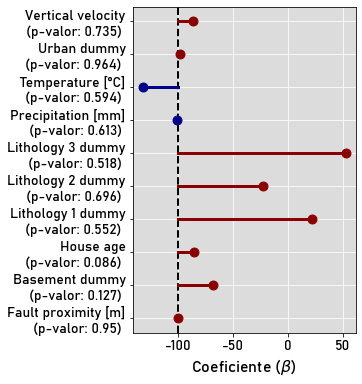

In [15]:
fig = plt.figure(figsize = (4,6))

plt.grid(True, which = 'both',  zorder = -3, c = 'w')

for i in range(len(lin_reg.params.iloc[:-1])):
    
    if lin_reg.params.iloc[i] > 0:
        plt.scatter((lin_reg.params.iloc[i]), Variables[i], s = 80, c = 'darkred', zorder = 4)
        plt.plot([1,(lin_reg.params.iloc[i])], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
    else:
        plt.scatter((lin_reg.params.iloc[i]), Variables[i], s = 80, c = 'darkblue', zorder = 4)
        plt.plot([1,(lin_reg.params.iloc[i])], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n(p-valor: '+str(round(lin_reg.pvalues.iloc[i],3))+') ')
        
ax = plt.gca()

ax.set_xlabel('Coeficiente ($\u03B2$)', family = 'bahnschrift', fontsize = 16)
ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
ax.set_xticklabels(np.arange(-150,150,50), family = 'bahnschrift', fontsize = 14)
ax.set_facecolor('gainsboro')

plt.axvline(0, c = 'k',ls='--', lw=2)

fig.savefig('Figures/Regresión_Lineal.png', dpi = 200, bbox_inches = 'tight')

### Logistic regression

,Beta,OR,p-values
0,0.000319,1.000319,0.313569
1,-0.605587,0.545754,0.588404
2,0.852806,2.346221,0.086902
3,2.187671,8.914431,1.000000
4,-1.906800,0.148555,1.000000
5,-0.232389,0.792638,1.000000
6,-0.026869,0.973489,0.695494
7,0.220234,1.246368,0.958540
8,-2.603546,0.074011,0.324466
9,-2.210760,0.109617,0.440303


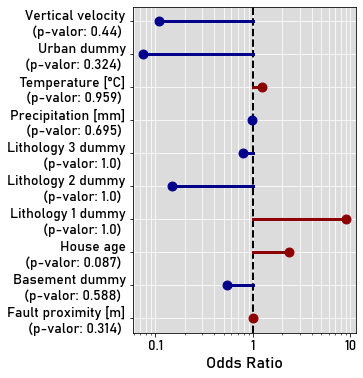

In [31]:
lgReg = LogisticRegression(max_iter = 50000, fit_intercept=False, solver = 'lbfgs',penalty = 'l2', C = 10)

lgReg.fit(X_log,y_log)

errores = (lgReg.predict(X_log)-y_log)

OR = np.exp(lgReg.coef_)

denom = (2.0*(1.0+np.cosh(lgReg.decision_function(X_log))))
denom = np.tile(denom,(X_log.shape[1],1)).T
F_ij = np.dot((X_log/denom).T,X_log) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.sqrt(np.abs(np.diagonal(Cramer_Rao)))
z_scores = lgReg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

DF_log = pd.DataFrame([lgReg.coef_[0], np.exp(lgReg.coef_[0]), p_values]).T
DF_log.columns = ['Beta', 'OR', 'p-values']
    
#     if p_values[2]<0.05:
#         print(i)

fig = plt.figure(figsize = (4,6))

plt.grid(True, which = 'both',  zorder = -3, c = 'w')

for i in range(len(lgReg.coef_[0][:-1])):
    if lgReg.coef_[0][:-1][i] > 0:
        plt.scatter(np.exp(lgReg.coef_[0][:-1][i]), Variables[i], s = 80, c = 'darkred', zorder = 4)
        plt.plot([1,np.exp(lgReg.coef_[0][:-1][i])], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
    else:
        plt.scatter(np.exp(lgReg.coef_[0][:-1][i]), Variables[i], s = 80, c = 'darkblue', zorder = 4)
        plt.plot([1,np.exp(lgReg.coef_[0][:-1][i])], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)


Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n(p-valor: '+str(round(p_values[i],3))+') ')

ax = plt.gca()

plt.xscale('log')
ax.set_xlabel('Odds Ratio', family = 'bahnschrift', fontsize = 16)
ax.set_xticks([0.1,1,10])
ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
ax.set_xticklabels(['0.1','1','10'], family = 'bahnschrift', fontsize = 14)
ax.set_facecolor('gainsboro')


plt.axvline(1, c = 'k',ls='--', lw=2)

fig.savefig('Figures/Regresión_Logística.png', dpi = 200, bbox_inches = 'tight')
DF_log

## Apply models to Household data :)

In [35]:
df_RnModel = pd.read_table("Independent variables/Houses_IndVar_model.txt", delimiter = ',')

df_RnModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725932 entries, 0 to 725931
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   OID_            725932 non-null  int64  
 1   Join_Count      725932 non-null  int64  
 2   TARGET_FID      725932 non-null  int64  
 3   Join_Count_1    725932 non-null  int64  
 4   TARGET_FID_1    725932 non-null  int64  
 5   COD_1           725932 non-null  object 
 6   MEAN_CONNPISOS  725932 non-null  float64
 7   MAX_CONNSOTANO  725932 non-null  int64  
 8   MEAN_BASEMENT   725932 non-null  float64
 9   MEAN_AGE_RANK   725932 non-null  float64
 10  ORIG_FID        725932 non-null  int64  
 11  SimboloUC       725932 non-null  object 
 12  Descripcion     725932 non-null  object 
 13  SueCodigo       725802 non-null  float64
 14  SueCSuelo       725802 non-null  float64
 15  SueAAdmini      725802 non-null  object 
 16  SueArea         725802 non-null  float64
 17  Shape_Leng

In [36]:
df_RnModel = df_RnModel.dropna()

df_RnModel['Urban_dummy'] = df_RnModel['SueCodigo'].apply(lambda df : 1 if df == 1 else 0)

# Create dummy variables
for i in df_RnModel['SimboloUC'].unique():
    df_RnModel['Lito_SGC_'+i.replace('-','_')[:10]] = df_RnModel.apply(lambda df : 1 if df['SimboloUC'] == i else 0, axis = 1)
    
df_RnModel['Constant'] = np.ones(len(df_RnModel))

df_RnModel = df_RnModel[(df_RnModel['SimboloUC'] == 'Q1-l')|
                        (df_RnModel['SimboloUC'] == 'Q-ca')|
                        (df_RnModel['SimboloUC'] == 'k1k6-Stm')]

df_RnModel = df_RnModel[['COD_1',
                         'NEAR_DIST', 
                         'MEAN_BASEMENT',
                         'MEAN_AGE_RANK',
                         'Lito_SGC_Q1_l',
                         'Lito_SGC_Q_ca',
                         'Lito_SGC_k1k6_Stm', 
                         'MEAN_12', 
                         'MEAN_1', 
                         'Urban_dummy', 
                         'MEAN', 
                         'Constant']]

In [37]:
df_RnModel.columns = ['COD',
                      'Fault_proximity',
                      'Basement_dummy',
                      'Age_rank',
                      'Lito_SGC_Q1_l', 
                      'Lito_SGC_Q_ca', 
                      'Lito_SGC_k1k6_Stm', 
                      'Precipitation', 
                      'Temperature', 
                      'Urban_dummy', 
                      'Vertical_velocity', 
                      'Constant']

### Linear regession

In [38]:
df_RnModel['LinReg'] = lin_reg.predict(df_RnModel.iloc[:,1:])

### Logistic regression

In [39]:
df_RnModel['LogReg'] = lgReg.predict_proba(df_RnModel.iloc[:,1:-1])[:,1]

C:\Users\mdomi\anaconda3\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Age_rank
- Basement_dummy
- Constant
- Fault_proximity
- Lito_SGC_Q1_l
- ...
Feature names seen at fit time, yet now missing:
- Constante
- DistanciaFalla
- Lito_SGC_Abanicos_a
- Lito_SGC_Arcillas,_
- Lito_SGC_Shales,_ca
- ...

  warnings.warn(message, FutureWarning)


In [40]:
df_RnModel.to_csv('Stat_models_results.csv')

(array([446470., 105099.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

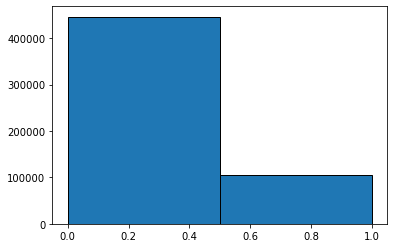

In [41]:
plt.hist(df_RnModel.LogReg, bins = np.arange(0,1.1,0.5), edgecolor = 'k')